## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

from scipy.stats import normaltest


# таков путь
import sys
sys.path.insert(1, '../../my_libs/')
from The_Mandalorian import this_is_the_way

#import warnings
#warnings.simplefilter("ignore", UserWarning)


In [85]:
import warnings
warnings.simplefilter("ignore", UserWarning)

Прочитаем наш файл с исходными данными:

In [86]:
taxi_data = pd.read_csv(this_is_the_way+"Project5_train_data.zip")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [87]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
pickup_datetime_range = [taxi_data['pickup_datetime'].max(), taxi_data['pickup_datetime'].min()]

print(f'Minimum: {pickup_datetime_range[1]} \nMaximum: {pickup_datetime_range[0]} ')

Minimum: 2016-01-01 00:00:17 
Maximum: 2016-06-30 23:59:39 


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [88]:
taxi_data.isnull().sum().sum()

np.int64(0)

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [89]:
taxi_data.describe(include = 'all')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,NaN,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id1209952,NaN,NaN,2016-05-16 19:40:28,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
mean,NaN,1.534950e+00,2016-04-01 10:10:24.940037120,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
min,NaN,1.000000e+00,2016-01-01 00:00:17,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,2016-02-17 16:46:04.249999872,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02
50%,NaN,2.000000e+00,2016-04-01 17:19:40,NaN,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,NaN,6.620000e+02
75%,NaN,2.000000e+00,2016-05-15 03:56:08.750000128,NaN,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,NaN,1.075000e+03
max,NaN,2.000000e+00,2016-06-30 23:59:39,NaN,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,NaN,3.526282e+06


In [90]:
print('Кол-во уникальных таксопарков: {:.0f}'.format(taxi_data['vendor_id'].nunique()))
print('Максимальное количество пассажиров: {:.0f}'.format(taxi_data['passenger_count'].max()))
print('Среднее время поездки в секундах: {:.0f}'.format(taxi_data['trip_duration'].mean()))
print('Медиана времени поездки в секундах: {:.0f}'.format(taxi_data['trip_duration'].median()))
print('Минимальное времени поездки в секундах: {:.0f}'.format(taxi_data['trip_duration'].min()))
print('Максимальное времени поездки в секундах: {:.0f}'.format(taxi_data['trip_duration'].max()))

Кол-во уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Среднее время поездки в секундах: 959
Медиана времени поездки в секундах: 662
Минимальное времени поездки в секундах: 1
Максимальное времени поездки в секундах: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [91]:
def add_datetime_features(df):
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime'], dayfirst=True).dt.date
    df['pickup_hour'] = pd.to_datetime(df['pickup_datetime'], dayfirst=True).dt.hour
    df['pickup_day_of_week'] = pd.to_datetime(df['pickup_datetime'], dayfirst=True).dt.dayofweek
    return df

taxi_data = add_datetime_features(taxi_data)

In [92]:
print('Поездок совершено в субботу: {}'.format(taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]))
print('Среднее количество поездок: {:.0f}'.format(taxi_data.groupby('pickup_date').size().mean()))

Поездок совершено в субботу: 220868
Среднее количество поездок: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [93]:
holiday_data = pd.read_csv(this_is_the_way+'holiday_data.csv', sep=';')
holiday_data.head(5)

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


In [94]:
def add_holiday_features(df_1, df_2):
    df_2['date'] = pd.to_datetime(df_2['date']).dt.date
    df_1['pickup_holiday'] = df_1['pickup_date'].isin(df_2['date']).astype(int)
    return df_1

In [95]:
taxi_data = add_holiday_features(taxi_data, holiday_data)
print('Медианная длительность поездки на такси в праздничные дни: {}'.format(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()))

Медианная длительность поездки на такси в праздничные дни: 585.0


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [96]:
osrm_data = pd.read_csv(this_is_the_way+'osrm_data_train.zip')
display(osrm_data.head(5))
print('Количество пропусков в данных: {}'.format(osrm_data.isna().sum().sum()))

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


Количество пропусков в данных: 0


In [97]:
def add_osrm_features(df_1, df_2):
    return df_1.merge(df_2[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], how='left', on = 'id')


In [98]:
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [99]:
print('Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM: {:.0f}'.format(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()))
print('Строк содержат пропуски: {}'.format(taxi_data.isna().any(axis=1).sum()))

Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM: 372
Строк содержат пропуски: 1


In [100]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [101]:
def add_geographical_features(df):
    # Применяем функцию Haversine для расчета расстояния
    df['haversine_distance'] = df.apply(
        lambda row: get_haversine_distance(
            row['pickup_latitude'], row['pickup_longitude'], 
            row['dropoff_latitude'], row['dropoff_longitude']
        ), axis=1
    )
    
    # Применяем функцию для расчета угла направления
    df['direction'] = df.apply(
        lambda row: get_angle_direction(
            row['pickup_latitude'], row['pickup_longitude'], 
            row['dropoff_latitude'], row['dropoff_longitude']
        ), axis=1
    )
    
    return df

taxi_data = add_geographical_features(taxi_data)
median_haversine_distance = round(taxi_data['haversine_distance'].median(), 2)
print(f"Медианное расстояние по формуле гаверсинуса: {median_haversine_distance} км")

Медианное расстояние по формуле гаверсинуса: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [102]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, n_init='auto', random_state=42)
kmeans.fit(coords)

def add_cluster_features(taxi_data, kmeans):
    # Применяем KMeans для предсказания кластера каждой поездки
    taxi_data['geo_cluster'] = kmeans.labels_
    return taxi_data


taxi_data = add_cluster_features(taxi_data, kmeans)

# Подсчёт количества поездок в каждом кластере и нахождение минимального
cluster_counts = taxi_data['geo_cluster'].value_counts()
min_cluster_size = cluster_counts.min()
print(f"Количество поездок в наименьшем кластере: {min_cluster_size}")

Количество поездок в наименьшем кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [103]:
weather_data = pd.read_csv(this_is_the_way+'weather_data.zip')
weather_data = weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
weather_data


,date,hour,temperature,visibility,wind speed,precip,events
0,2015-12-31,2,7.8,8.0,5.6,0.8,NaN
1,2015-12-31,3,7.2,12.9,7.4,0.3,NaN
2,2015-12-31,4,7.2,12.9,0.0,0.0,NaN
3,2015-12-31,5,7.2,14.5,7.4,0.0,NaN
4,2015-12-31,6,7.2,11.3,5.6,0.0,NaN
...,...,...,...,...,...,...,...
8782,2017-01-01,21,5.0,16.1,7.4,0.0,NaN
8783,2017-01-01,22,5.6,16.1,9.3,0.0,NaN
8784,2017-01-01,23,5.6,16.1,7.4,0.0,NaN
8785,2017-01-02,0,5.0,16.1,7.4,0.0,NaN


In [104]:
weather_data.events.value_counts()

events
Rain    379
Snow     74
Fog       2
Name: count, dtype: int64

In [105]:
def add_weather_features(df_1, df_2):
    
    df_2['date'] = pd.to_datetime(df_2['date'], format='%Y-%m-%d').dt.date
    df = df_1.merge(df_2, how='left', left_on = ['pickup_date', 'pickup_hour'], right_on = ['date', 'hour'])
    df.drop(['date', 'hour'], axis=1, inplace=True)
    return df

In [106]:
taxi_data = add_weather_features(taxi_data, weather_data)


In [107]:
print('Поездок совершено в снежную погоду {}'.format(taxi_data[taxi_data['events']=='Snow'].shape[0]))
print('Процент пропусков в столбце с погодными условиями {:.2f}'.format(taxi_data['temperature'].isnull().mean() * 100))

Поездок совершено в снежную погоду 13126
Процент пропусков в столбце с погодными условиями 0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [108]:
def fill_null_weather_data(trip_data):
    df = trip_data.copy()
    
    change_cols = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in change_cols:
        df[col] = df[col].fillna(df[col].median())
    
    df.fillna({'events': 'None'}, inplace=True)  # Или используйте df.fillna({'events': 'None'}, inplace=True)

    change_cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in change_cols:
        df[col] = df.groupby('pickup_date')[col].transform(lambda x: x.fillna(x.median()))
    
    return df

In [109]:
taxi_data = fill_null_weather_data(taxi_data)

In [110]:
print('Медиана с столбце temperature после заполнения пропусков: {}'.format(round(taxi_data['temperature'].median(), 1)))

Медиана с столбце temperature после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


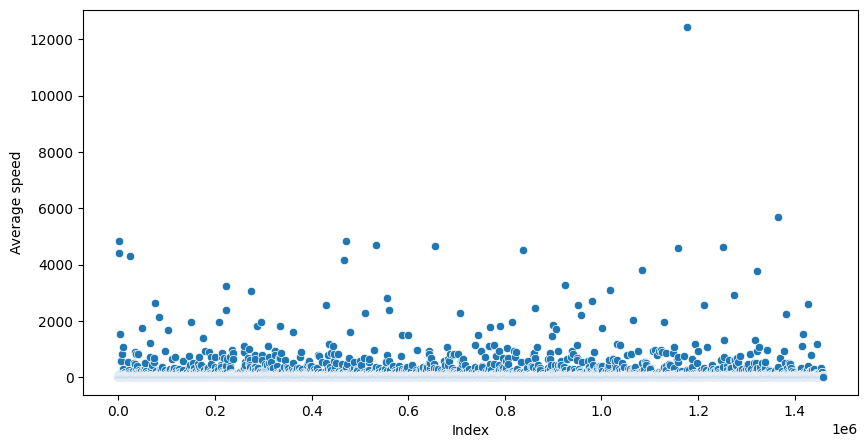

In [111]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [112]:
print('Выбросов по признаку длительности поездки: {}'.format(taxi_data[taxi_data['trip_duration'] > 86400].shape[0]))
print('Выбросов по признаку скорости: {}'.format(taxi_data[taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300].shape[0]))

taxi_data = taxi_data[taxi_data['trip_duration'] <= 86400]
taxi_data = taxi_data[taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 <= 300]
taxi_data = taxi_data.reset_index(drop=True)

Выбросов по признаку длительности поездки: 4
Выбросов по признаку скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [113]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

Text(0.5, 1.0, 'Гистограмма распределения длительности поездок в логарифмированном мастштабе')

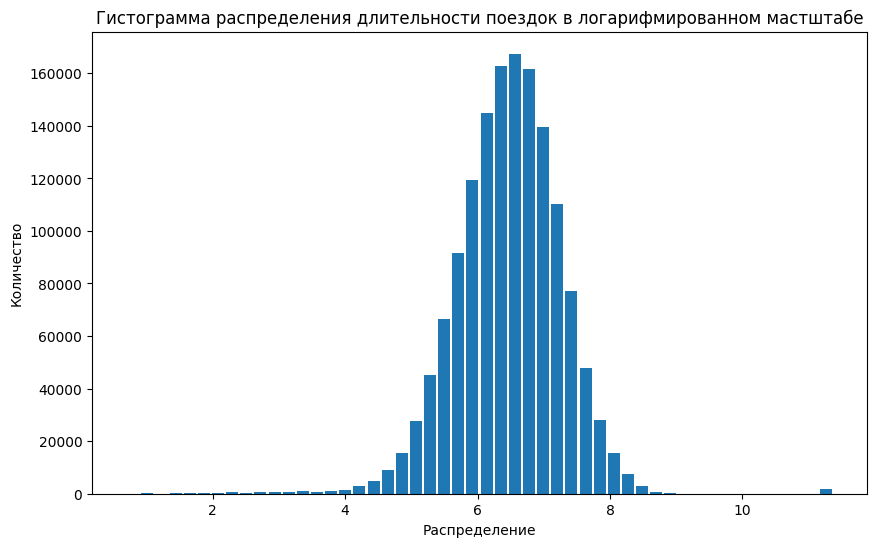

In [114]:
plt.figure(figsize=(10, 6)) 
taxi_data['trip_duration_log'].plot.hist(bins=50, rwidth=0.85)

plt.xlabel('Распределение')
plt.ylabel('Количество')
plt.title('Гистограмма распределения длительности поездок в логарифмированном мастштабе')

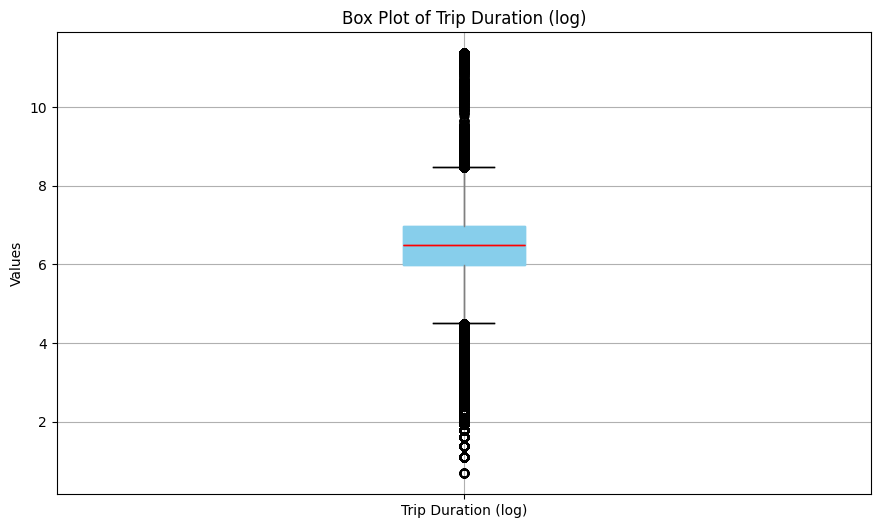

In [115]:
plt.figure(figsize=(10.5, 6)) 
taxi_data['trip_duration_log'].plot.box(patch_artist=True, color=dict(boxes='SkyBlue', whiskers='Gray', medians='Red', caps='Black'))
taxi_data['trip_duration_log'].plot.box(patch_artist=True, color=dict(boxes='SkyBlue', whiskers='Gray', medians='Red', caps='Black'))
plt.title('Box Plot of Trip Duration (log)')  # Добавление заголовка
plt.ylabel('Values')  # Подпись оси Y
plt.grid(True)  # Добавление сетки
plt.xticks([1], ['Trip Duration (log)'])  # Устанавливаем свою метку

plt.show()

In [116]:

trip_duration_log = taxi_data['trip_duration_log']
stat, p_value = normaltest(trip_duration_log)
alpha = 0.05
print(f'Statistic: {stat}, p-value: {p_value}')
if p_value < alpha:
    print("Нулевая гипотеза отклоняется: данные не распределены нормально.")
else:
    print("Нулевая гипотеза не отклоняется: данные распределены нормально.")

Statistic: 138350.16605405, p-value: 0.0
Нулевая гипотеза отклоняется: данные не распределены нормально.


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

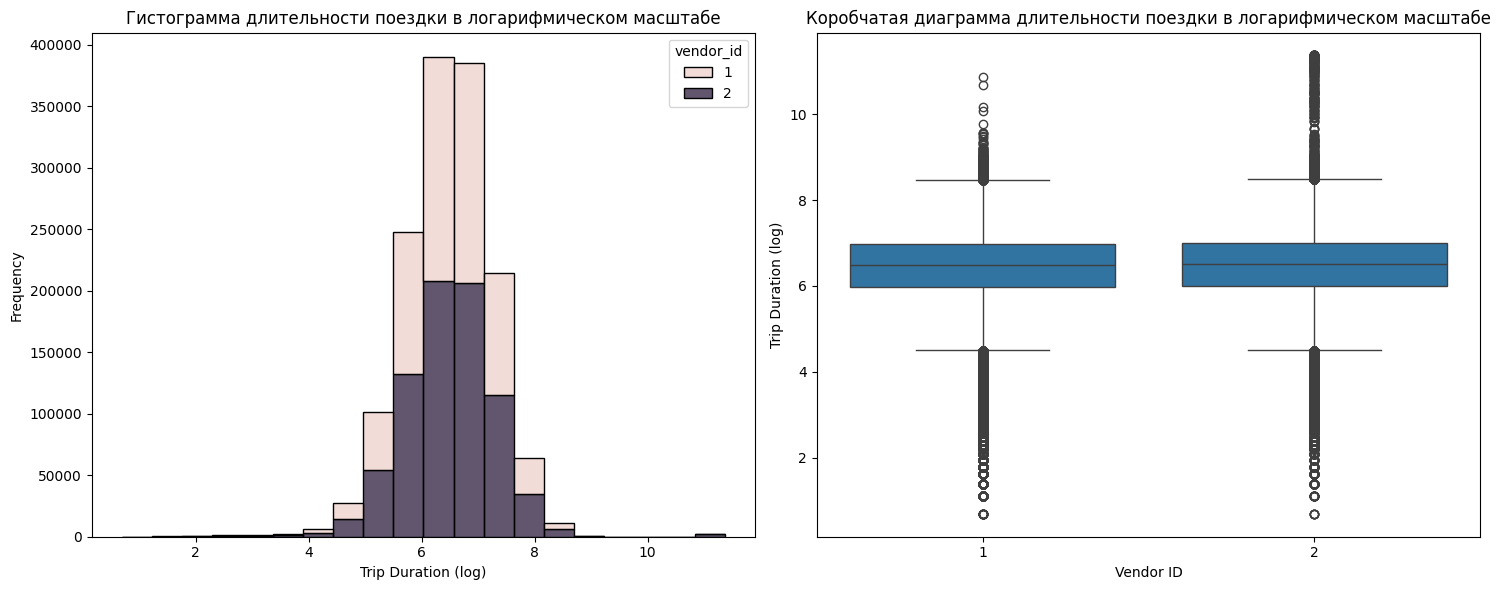

In [117]:
# Создание фигуры с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', multiple='stack', bins=20, ax=axs[0])
axs[0].set_title('Гистограмма длительности поездки в логарифмическом масштабе')
axs[0].set_xlabel('Trip Duration (log)')
axs[0].set_ylabel('Frequency')

# Коробчатая диаграмма
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', ax=axs[1])
axs[1].set_title('Коробчатая диаграмма длительности поездки в логарифмическом масштабе')
axs[1].set_xlabel('Vendor ID')
axs[1].set_ylabel('Trip Duration (log)')

# Показать графики
plt.tight_layout()
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

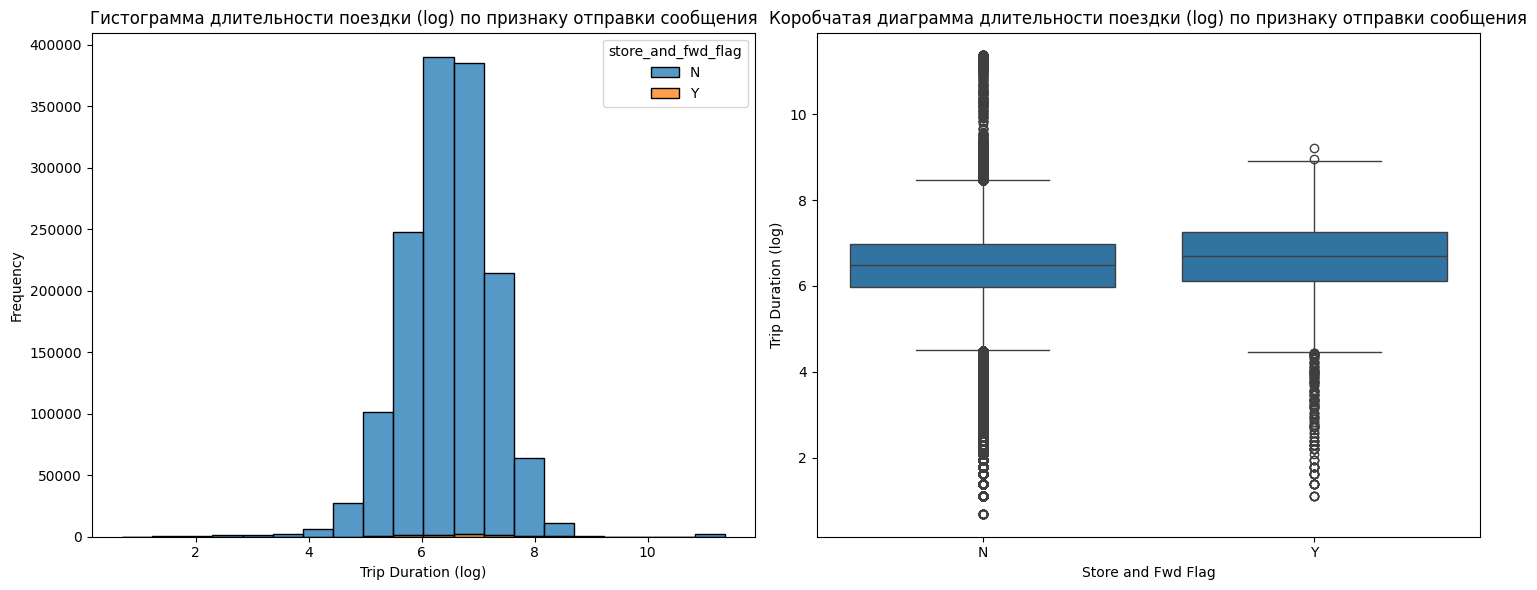

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', multiple='stack', bins=20, ax=axs[0])
axs[0].set_title('Гистограмма длительности поездки (log) по признаку отправки сообщения')
axs[0].set_xlabel('Trip Duration (log)')
axs[0].set_ylabel('Frequency')

# Коробчатая диаграмма
sns.boxplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log', ax=axs[1])
axs[1].set_title('Коробчатая диаграмма длительности поездки (log) по признаку отправки сообщения')
axs[1].set_xlabel('Store and Fwd Flag')
axs[1].set_ylabel('Trip Duration (log)')

plt.tight_layout()
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

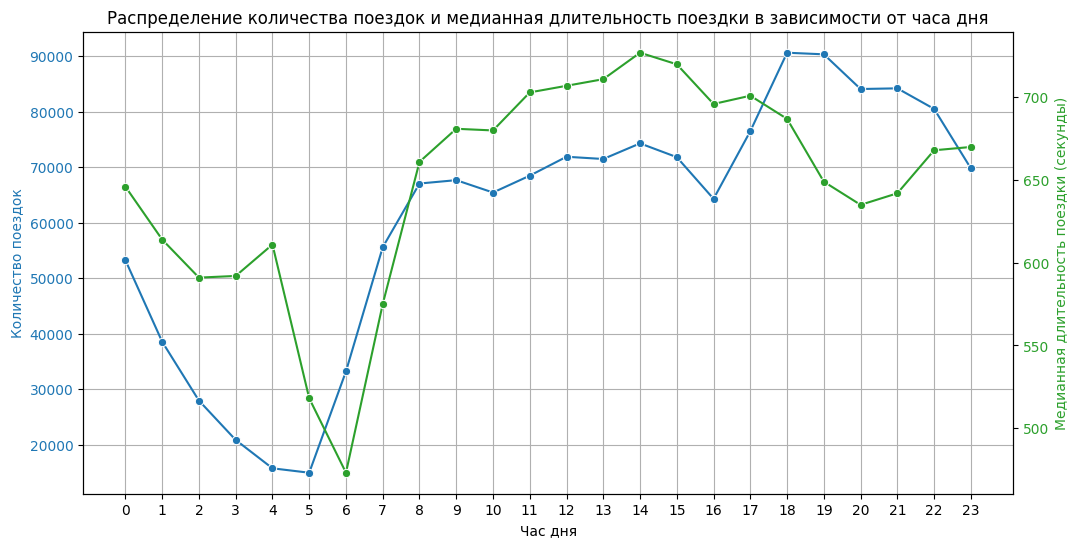

In [119]:
# Вычисление количества поездок по часам дня
trip_counts = taxi_data['pickup_hour'].value_counts().sort_index()

# Вычисление медианной длительности поездки по часам дня
median_trip_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()

# Создание фигуры и основной оси
fig, ax1 = plt.subplots(figsize=(12, 6))

# Построение линии количества поездок
color = 'tab:blue'
ax1.set_xlabel('Час дня')
ax1.set_ylabel('Количество поездок', color=color)
sns.lineplot(x=trip_counts.index, y=trip_counts.values, marker='o', color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(0, 24))
ax1.grid(True)

# Создание второй оси
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Медианная длительность поездки (секунды)', color=color)
sns.lineplot(data=median_trip_duration, x='pickup_hour', y='trip_duration', marker='o', color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

# Заголовок графика
plt.title('Распределение количества поездок и медианная длительность поездки в зависимости от часа дня')

# Показать график
plt.show()


### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


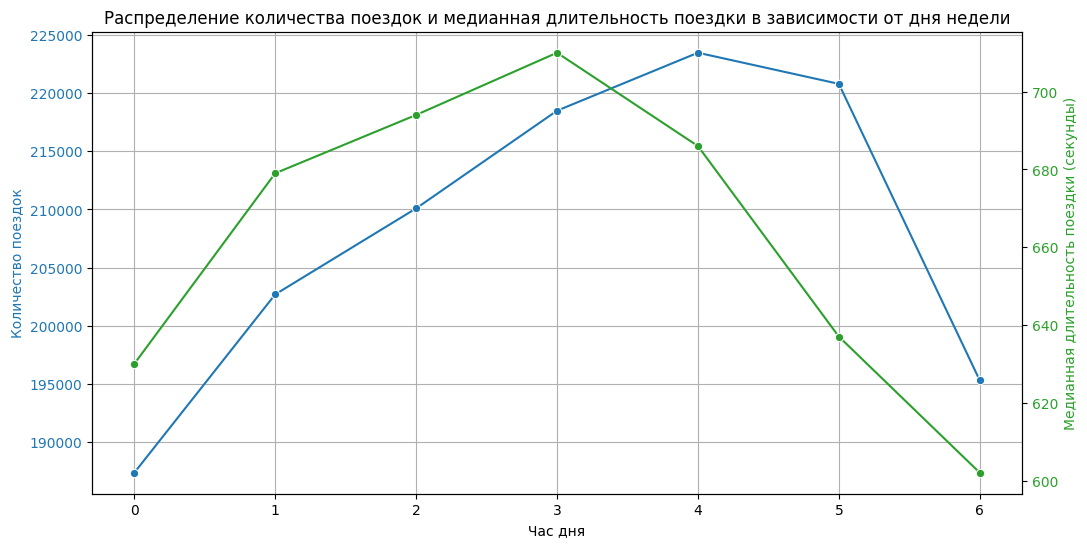

In [120]:
# Вычисление количества поездок от дня недели
trip_counts = taxi_data['pickup_day_of_week'].value_counts().sort_index()

# Вычисление медианной длительности поездки от дня недели
median_trip_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()

# Создание фигуры и основной оси
fig, ax1 = plt.subplots(figsize=(12, 6))

# Построение линии количества поездок
color = 'tab:blue'
ax1.set_xlabel('Час дня')
ax1.set_ylabel('Количество поездок', color=color)
sns.lineplot(x=trip_counts.index, y=trip_counts.values, marker='o', color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(0, 24))
ax1.grid(True)

# Создание второй оси
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Медианная длительность поездки (секунды)', color=color)
sns.lineplot(data=median_trip_duration, x='pickup_day_of_week', y='trip_duration', marker='o', color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

# Заголовок графика
plt.title('Распределение количества поездок и медианная длительность поездки в зависимости от дня недели')

# Показать график
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

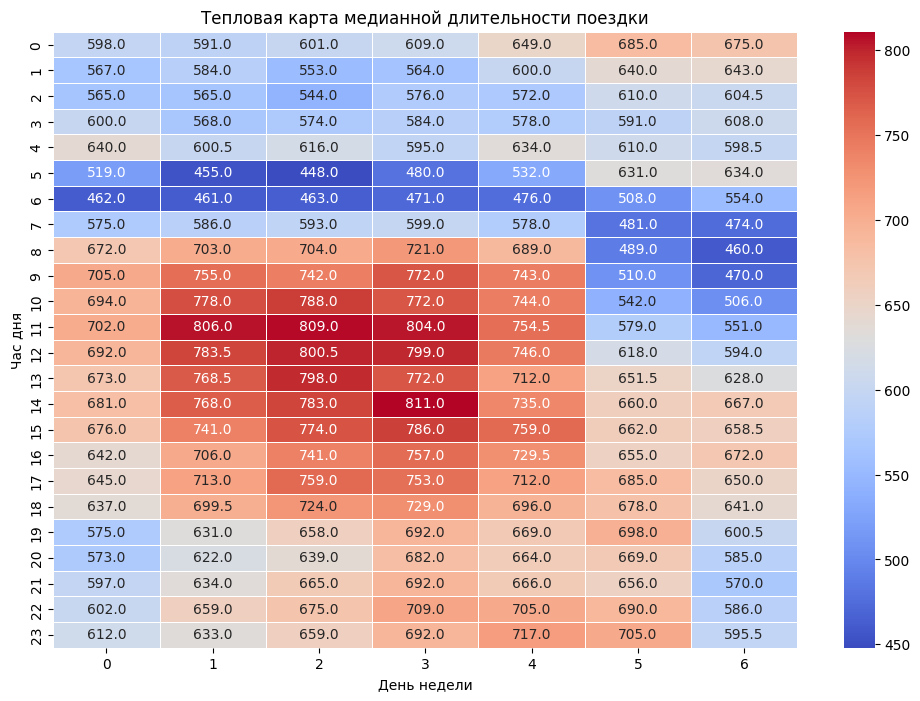

In [121]:
# Построение сводной таблицы
pivot_table = taxi_data.pivot_table(index='pickup_hour', columns='pickup_day_of_week', values='trip_duration', aggfunc='median')

# Визуализация тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.1f', linewidths=.5)
plt.title('Тепловая карта медианной длительности поездки')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


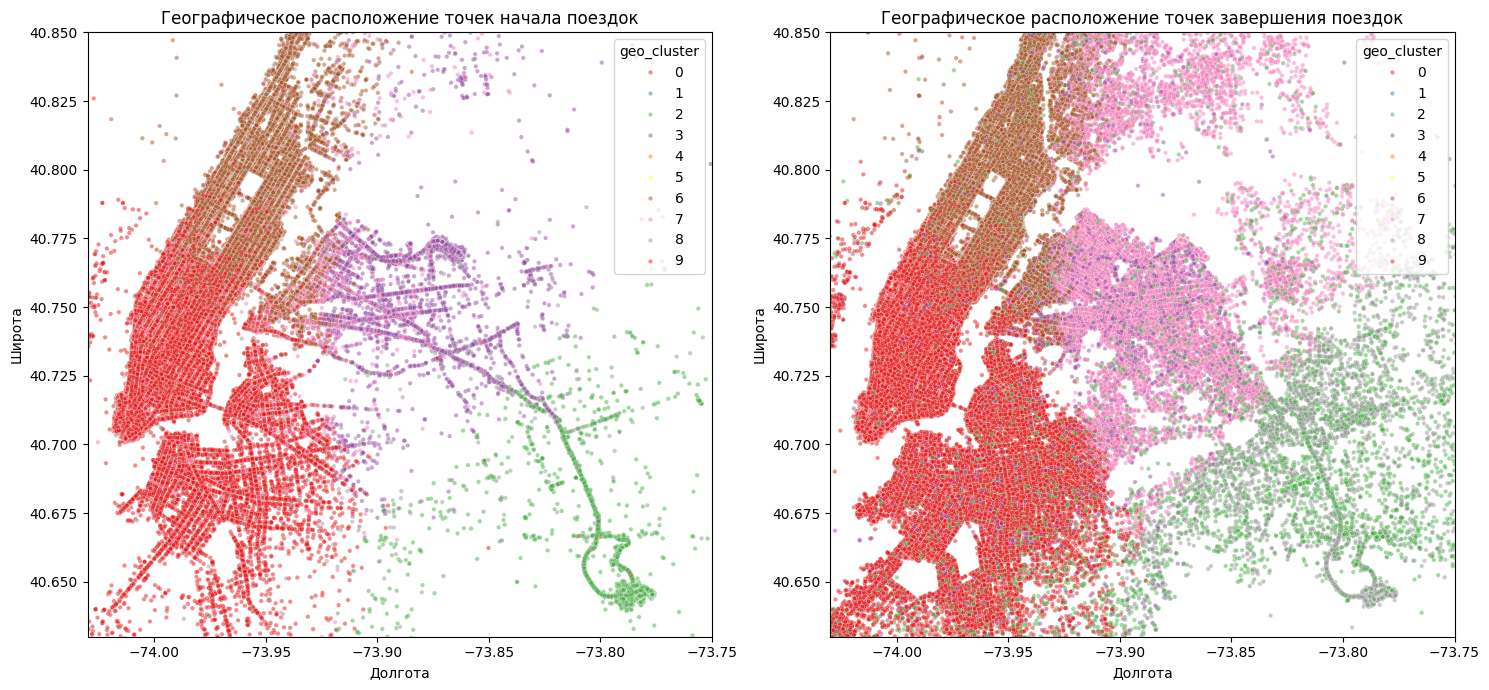

In [122]:
# Границы Нью-Йорка
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Создание фигуры для диаграмм рассеяния
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Первая диаграмма рассеяния (точки начала поездок)
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', data=taxi_data, ax=axs[0], alpha=0.5, s=10, palette='Set1')
axs[0].set_title('Географическое расположение точек начала поездок')
axs[0].set_xlabel('Долгота')
axs[0].set_ylabel('Широта')
axs[0].set_xlim(city_long_border)
axs[0].set_ylim(city_lat_border)

# Вторая диаграмма рассеяния (точки завершения поездок)
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', data=taxi_data, ax=axs[1], alpha=0.5, s=10, palette='Set1')
axs[1].set_title('Географическое расположение точек завершения поездок')
axs[1].set_xlabel('Долгота')
axs[1].set_ylabel('Широта')
axs[1].set_xlim(city_long_border)
axs[1].set_ylim(city_lat_border)

# Показать графики
plt.tight_layout()


In [123]:
in_city_pickup_mask = (
    (taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1]) &
    (taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1])
)

# Создание маски для точек завершения поездок внутри границ Нью-Йорка
in_city_dropoff_mask = (
    (taxi_data['dropoff_longitude'] >= city_long_border[0]) & (taxi_data['dropoff_longitude'] <= city_long_border[1]) &
    (taxi_data['dropoff_latitude'] >= city_lat_border[0]) & (taxi_data['dropoff_latitude'] <= city_lat_border[1])
)

# Уникальные кластеры внутри города
clusters_in_city = pd.concat([taxi_data[in_city_pickup_mask]['geo_cluster'], taxi_data[in_city_dropoff_mask]['geo_cluster']]).unique()

# Уникальные кластеры всего
all_clusters = taxi_data['geo_cluster'].unique()

# Кластеры, находящиеся за границами Нью-Йорка
clusters_outside_city = set(all_clusters) - set(clusters_in_city)

print(f'Количество кластеров внутри Нью-Йорка: {len(clusters_in_city)}')
print(f'Количество кластеров за границами Нью-Йорка: {len(clusters_outside_city)}')
print(f'Кластеры за границами Нью-Йорка: {clusters_outside_city}')

Количество кластеров внутри Нью-Йорка: 7
Количество кластеров за границами Нью-Йорка: 3
Кластеры за границами Нью-Йорка: {np.int32(1), np.int32(4), np.int32(5)}


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [124]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [125]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [126]:
train_data.drop(['dropoff_datetime', 'id'], axis=1, inplace=True)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [127]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [128]:
train_data.vendor_id = train_data.vendor_id.apply(lambda x: 0 if x==1 else 1)
train_data.store_and_fwd_flag = train_data.store_and_fwd_flag.apply(lambda x: 0 if x=='N' else 1)

In [129]:
print('Cреднее по закодированному столбцу vendor_id {}'.format(round(train_data.vendor_id.mean(), 2)))
print('Cреднее по закодированному столбцу store_and_fwd_flag {}'.format(round(train_data.store_and_fwd_flag.mean(), 3)))

Cреднее по закодированному столбцу vendor_id 0.53
Cреднее по закодированному столбцу store_and_fwd_flag 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [130]:
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder.fit(train_data[columns_to_change])
data_onehot = pd.DataFrame(data=one_hot_encoder.transform(train_data[columns_to_change]).toarray(), columns=one_hot_encoder.get_feature_names_out(columns_to_change))
one_hot_encoder.get_feature_names_out(columns_to_change)

array(['pickup_day_of_week_1', 'pickup_day_of_week_2',
       'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_1',
       'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4', 'geo_cluster_5',
       'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9',
       'events_None', 'events_Rain', 'events_Snow'], dtype=object)

Добавим полученную таблицу с закодированными признаками:

In [131]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [132]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [133]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [134]:
from sklearn.feature_selection import SelectKBest, f_regression

select = SelectKBest(score_func=f_regression, k=25)
select.fit(X_train, y_train_log)
best_features = select.get_feature_names_out()
best_features

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3',
       'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8'], dtype=object)

In [135]:
X_train = X_train[best_features]
X_valid = X_valid[best_features]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [136]:
scaler = preprocessing.MinMaxScaler()
col_names = X_train.columns
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=col_names)

In [137]:
print('Cреднее арифметическое для первого предиктора {}'.format(round(X_valid.iloc[:, 0].mean(), 2)))

Cреднее арифметическое для первого предиктора 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [138]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train_log)

y_pred = linreg.predict(X_train)
RMSLE = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred))

print(f'RMSLE для тренировочной {RMSLE:.2f}')

y_pred = linreg.predict(X_valid)
RMSLE = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred))

print(f'RMSLE для валидационной {RMSLE:.2f}')

RMSLE для тренировочной 0.54
RMSLE для валидационной 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [139]:
def get_metric(fitmodel, X, y, method):
    y_pred = fitmodel.predict(X)
    metric = method(y, y_pred)
    return metric
def get_RMSLE(y, y_pred):
    RMSLE = np.sqrt(metrics.mean_squared_error(y, y_pred))
    return RMSLE

In [140]:

pols = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

polylr = linear_model.LinearRegression().fit(pols.fit_transform(X_train), y_train_log)

RMSLE_train = get_metric(polylr, pols.fit_transform(X_train), y_train_log, get_RMSLE)
print(f'RMSLE для тренировочной {RMSLE_train:.2f}')

RMSLE_val = get_metric(polylr, pols.fit_transform(X_valid), y_valid_log, get_RMSLE)
print(f'RMSLE для валидационной {RMSLE_val:.2f}')

RMSLE для тренировочной 0.47
RMSLE для валидационной 0.69


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [141]:
pols = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
polylrL2 = linear_model.Ridge().fit(pols.fit_transform(X_train), y_train_log)
RMSLE_train = get_metric(polylrL2, pols.fit_transform(X_train), y_train_log, get_RMSLE)
print(f'RMSLE для тренировочной {RMSLE_train:.2f}')

RMSLE_val = get_metric(polylrL2, pols.fit_transform(X_valid), y_valid_log, get_RMSLE)
print(f'RMSLE для валидационной {RMSLE_val:.2f}')

RMSLE для тренировочной 0.48
RMSLE для валидационной 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [142]:
desTree = tree.DecisionTreeRegressor().fit(X_train, y_train_log)
RMSLE_train = get_metric(desTree, X_train, y_train_log, get_RMSLE)
print(f'RMSLE для тренировочной {RMSLE_train:.2f}')

RMSLE_val = get_metric(desTree, X_valid, y_valid_log, get_RMSLE)
print(f'RMSLE для валидационной {RMSLE_val:.2f}')

RMSLE для тренировочной 0.00
RMSLE для валидационной 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [143]:
max_depths = range(7, 20)

RMSLE_train_list = []
RMSLE_val_list = []
for depth in max_depths:
    desTree = tree.DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train_log)
    RMSLE_train_list.append(get_metric(desTree, X_train, y_train_log, get_RMSLE))
    RMSLE_val_list.append(get_metric(desTree, X_valid, y_valid_log, get_RMSLE))
    
    

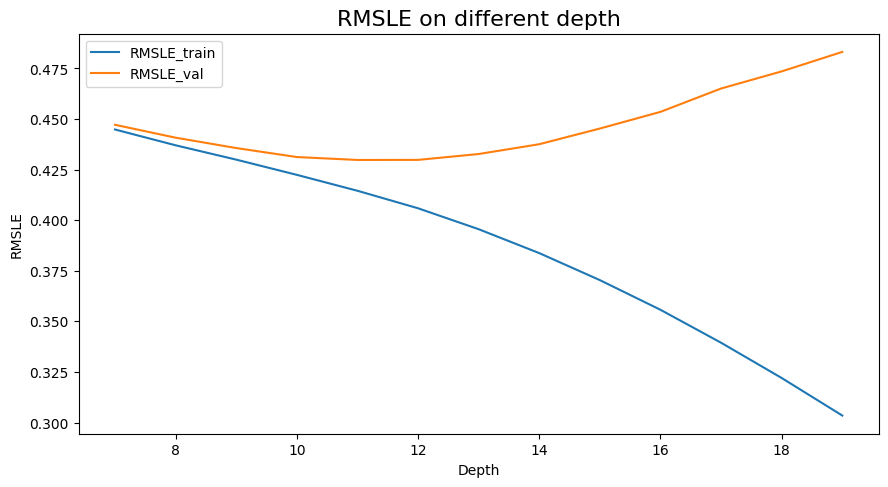

In [144]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(max_depths, RMSLE_train_list, label='RMSLE_train')
axes.plot(max_depths, RMSLE_val_list, label='RMSLE_val')
axes.set_title('RMSLE on different depth', fontsize=16)
axes.set_xlabel('Depth')
axes.set_ylabel('RMSLE')
axes.legend();

In [145]:
print(f'RMSLE_train на 12 глубине: {RMSLE_train_list[5]:.2f}, RMSLE_val на 12 глубине: {RMSLE_val_list[5]:.2f}')

RMSLE_train на 12 глубине: 0.41, RMSLE_val на 12 глубине: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [146]:
randForest = ensemble.RandomForestRegressor(n_estimators = 200,
                                            max_depth = 12,
                                            criterion = 'squared_error',
                                            min_samples_split = 20,
                                            random_state = 42,
                                            verbose=True,
                                            n_jobs=-1
                                           ).fit(X_train, y_train_log)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished


In [147]:
RMSLE_train = get_metric(randForest, X_train, y_train_log, get_RMSLE)
print(f'RMSLE для тренировочной {RMSLE_train:.2f}')

RMSLE_val = get_metric(randForest, X_valid, y_valid_log, get_RMSLE)
print(f'RMSLE для валидационной {RMSLE_val:.2f}')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


RMSLE для тренировочной 0.40


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


RMSLE для валидационной 0.41


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.2s finished


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [148]:
gradBoost = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                               n_estimators=100,
                                               max_depth=6,
                                               min_samples_split=30,
                                               random_state=42,
                                                verbose=True).fit(X_train, y_train_log)

      Iter       Train Loss   Remaining Time 
         1           0.3110           10.30m
         2           0.2247           10.07m
         3           0.1987            9.94m
         4           0.1876            9.78m
         5           0.1822            9.67m
         6           0.1787            9.52m
         7           0.1753            9.41m
         8           0.1725            9.29m
         9           0.1698            9.16m
        10           0.1685            9.15m
        20           0.1589            8.61m
        30           0.1549            7.52m
        40           0.1507            6.37m
        50           0.1480            5.26m
        60           0.1452            4.17m
        70           0.1438            3.11m
        80           0.1413            2.07m
        90           0.1397            1.03m
       100           0.1382            0.00s


In [149]:
RMSLE_train = get_metric(gradBoost, X_train, y_train_log, get_RMSLE)
RMSLE_val = get_metric(gradBoost, X_valid, y_valid_log, get_RMSLE)

print(f'RMSLE для тренировочной {RMSLE_train:.2f}')
print(f'RMSLE для валидационной {RMSLE_val:.2f}')

RMSLE для тренировочной 0.37
RMSLE для валидационной 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


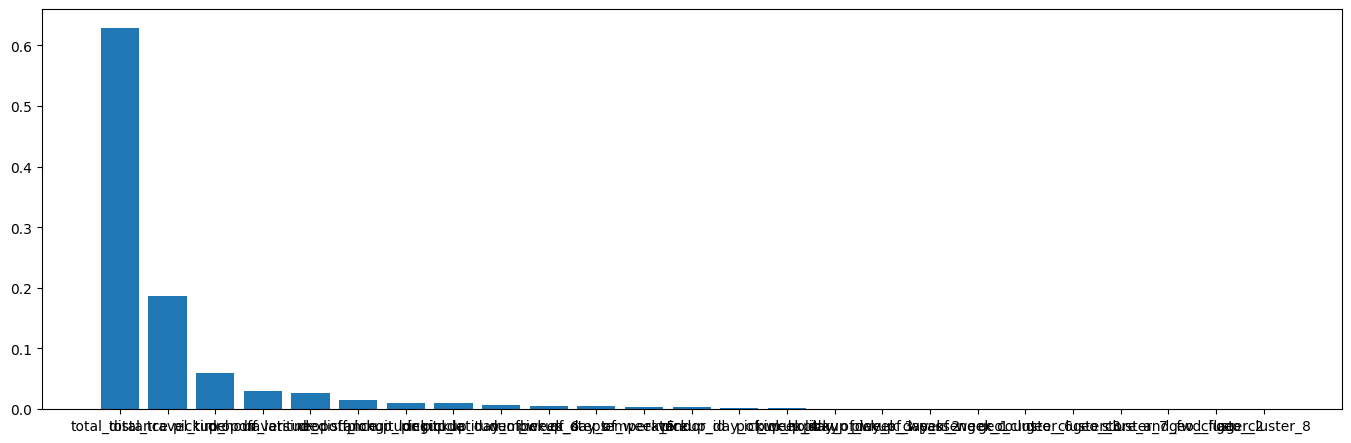

In [150]:
feature_imp = gradBoost.feature_importances_

feature_imp_data = pd.DataFrame(index=X_train.columns, data=feature_imp, columns=['importance'])

feature_imp_data = feature_imp_data.sort_values(by='importance', ascending=False)
fig = plt.figure(figsize=(13, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = feature_imp_data.index, height = feature_imp_data.importance);

In [151]:
feature_imp_data

,importance
total_distance,0.628066
total_travel_time,0.186897
pickup_hour,0.059127
dropoff_latitude,0.029735
haversine_distance,0.026424
dropoff_longitude,0.014925
pickup_longitude,0.010882
pickup_latitude,0.010695
pickup_day_of_week_6,0.007621
number_of_steps,0.005739


### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [152]:
y_pred_log = gradBoost.predict(X_valid)

y_pred = np.exp(y_pred_log) - 1
y_valid = np.exp(y_valid_log) - 1

MeAE = metrics.median_absolute_error(y_valid, y_pred)


print(f'Значение метрики MeAE {round(MeAE / 60, 1):.2f}')

Значение метрики MeAE 1.80


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [82]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)